In [1]:
import os
os.chdir("..")

In [2]:
from implicit_filter import JaxFilter, convert_to_wavenumbers, make_tri
import math
import numpy as np

# Create mesh
---

### Define mesh parameters

In [3]:
# ============
# Mesh size:
# ============
Lx = 1000
Ly = Lx
# ===========
# Cell size and x,y vectors
# ===========
dxm = 1
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = False
r_earth = 6400

### Create mesh

In [4]:
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)
# =============
# 2D regular array of points,
# their x and y coordinates.
# We will create triangles later
# =============

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create sythetic data

This process is repeated to create multiple input data

In [5]:
data = []
for i in range(10):  
    tt = 50 * (np.random.random(xcoord.shape) - 0.5)
    ttf = np.fft.fft2(tt)
    # ============
    # Make spectrum red
    # ============
    espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
    kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers
    
    for mx in range(nx):
        for my in range(ny):
            ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
            if my == 0 and mx == 0:  # Remove area mean
                ttf[my, mx] = 0.0
            else:  # Adjust amplitudes
                tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
                ttf[my, mx] = tmp
            if ll + 1 <= nx // 2 + 1:
                espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])
    
    espectrum = espectrum / np.power(nx, 4)
    tt = np.real(np.fft.ifft2(ttf))
    tt = np.reshape(tt, [nx * ny])
    data.append(tt)  # We expect that it will show - 2 spectrum

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_21825/2329457067.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])


### Reshape arrays and create triangulation

In [6]:
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])

In [7]:
tri = make_tri(nodnum, nx, ny)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])

# Filtering
---

### Define wavelength

Using build-in function to get wavenumber corresponding to 100 km filter

In [8]:
Kc = convert_to_wavenumbers(100, dxm)

In [9]:
%%time
jf = JaxFilter()
jf.prepare(n2d, e2d, tri, xcoord, ycoord, meshtype, cartesian, cyclic_length)

CPU times: user 18.4 s, sys: 110 ms, total: 18.5 s
Wall time: 18.9 s


Comparing simple for-loop based implementation with optimized method

In [11]:
%%time
output = []
for tt in data:
    tts = jf.compute(1, Kc, tt)
    output.append(tts)

CPU times: user 8min 5s, sys: 5min 13s, total: 13min 19s
Wall time: 1min 13s


In [10]:
%%time
output = jf.many_compute(1, Kc, data)

CPU times: user 7min 53s, sys: 5min 41s, total: 13min 35s
Wall time: 1min 17s


In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [13]:
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

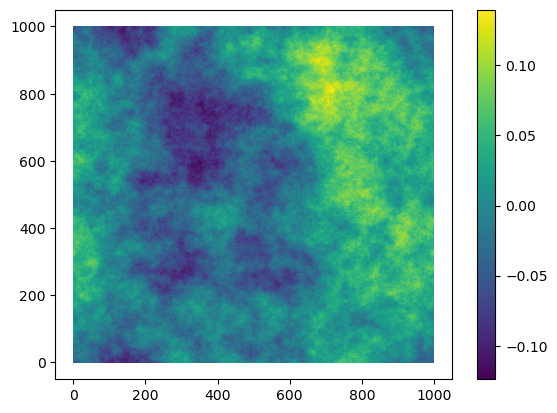

In [14]:
plt.tripcolor(triang, data[-1])
plt.colorbar()

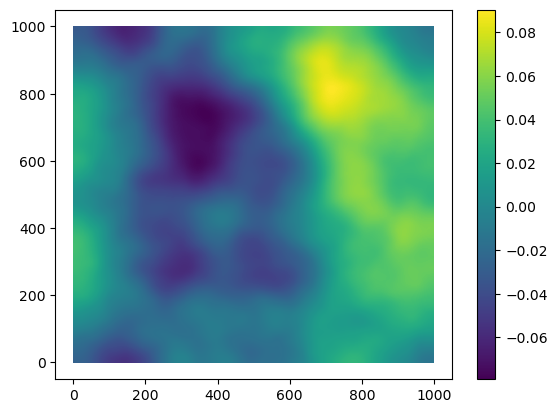

In [15]:
plt.tripcolor(triang, output[-1])
plt.colorbar()